In [1]:
# Logit (no outside) with 1 brand + 2 generics (asymmetric)
# ----------------------------------------------------------
import math

def shares_no_outside_asym(pb, pg1, pg2, Vb, Vg1, Vg2, alpha):
    """
    Returns (s_b, s_g1, s_g2). Shares sum to 1.
    """
    db  = Vb  - alpha*pb
    dg1 = Vg1 - alpha*pg1
    dg2 = Vg2 - alpha*pg2
    eb, eg1, eg2 = math.exp(db), math.exp(dg1), math.exp(dg2)
    Z = eb + eg1 + eg2
    sb  = eb  / Z
    sg1 = eg1 / Z
    sg2 = eg2 / Z
    return sb, sg1, sg2

def solve_prices_no_outside_asym(Vb, Vg1, Vg2, alpha, MCb, MCg1, MCg2,
                                 p0_b=None, p0_g1=None, p0_g2=None,
                                 damping=0.6, tol=1e-10, max_iter=800):
    """
    Fixed-point iteration on the single-product logit FOCs (no outside):
        p_i = c_i + 1 / (alpha * (1 - s_i)),  for i in {b,g1,g2}.
    Shares depend on (p_b, p_g1, p_g2) via logit.

    Returns dict with convergence flag, prices, shares, profits, iterations.
    """
    # sensible initial guesses
    inv_a = 1.0/alpha
    if p0_b  is None: p0_b  = MCb  + inv_a
    if p0_g1 is None: p0_g1 = MCg1 + inv_a
    if p0_g2 is None: p0_g2 = MCg2 + inv_a

    pb, pg1, pg2 = float(p0_b), float(p0_g1), float(p0_g2)

    for it in range(1, max_iter+1):
        sb, sg1, sg2 = shares_no_outside_asym(pb, pg1, pg2, Vb, Vg1, Vg2, alpha)

        # FOC right-hand sides
        pb_star  = MCb  + 1.0/(alpha * (1.0 - sb))
        pg1_star = MCg1 + 1.0/(alpha * (1.0 - sg1))
        pg2_star = MCg2 + 1.0/(alpha * (1.0 - sg2))

        # damped update
        new_pb  = (1.0 - damping)*pb  + damping*pb_star
        new_pg1 = (1.0 - damping)*pg1 + damping*pg1_star
        new_pg2 = (1.0 - damping)*pg2 + damping*pg2_star

        # convergence check
        if max(abs(new_pb-pb), abs(new_pg1-pg1), abs(new_pg2-pg2)) < tol:
            pb, pg1, pg2 = new_pb, new_pg1, new_pg2
            sb, sg1, sg2 = shares_no_outside_asym(pb, pg1, pg2, Vb, Vg1, Vg2, alpha)
            return {
                "converged": True, "iterations": it,
                "pb": pb, "pg1": pg1, "pg2": pg2,
                "sb": sb, "sg1": sg1, "sg2": sg2,
                "profit_b":  (pb  - MCb)  * sb,
                "profit_g1": (pg1 - MCg1) * sg1,
                "profit_g2": (pg2 - MCg2) * sg2,
            }

        pb, pg1, pg2 = new_pb, new_pg1, new_pg2

    # not converged
    sb, sg1, sg2 = shares_no_outside_asym(pb, pg1, pg2, Vb, Vg1, Vg2, alpha)
    return {
        "converged": False, "iterations": max_iter,
        "pb": pb, "pg1": pg1, "pg2": pg2,
        "sb": sb, "sg1": sg1, "sg2": sg2,
        "profit_b":  (pb  - MCb)  * sb,
        "profit_g1": (pg1 - MCg1) * sg1,
        "profit_g2": (pg2 - MCg2) * sg2,
    }

# --------------------------
# Example usage / sanity check
# --------------------------
if __name__ == "__main__":
    # Example primitives (you can change these):
    alpha = 0.02041
    Vb, Vg1, Vg2 = 1.502, 0.195, 0.195   # allow Vg1 != Vg2 later
    MCb, MCg1, MCg2 = 10.8, 11.5, 11.5

    res = solve_prices_no_outside_asym(Vb, Vg1, Vg2, alpha, MCb, MCg1, MCg2)
    print(res)


{'converged': True, 'iterations': 29, 'pb': 107.94604171264376, 'pg1': 77.0174473824976, 'pg2': 77.0174473824976, 'sb': 0.49565016203366247, 'sg1': 0.2521749189831687, 'sg2': 0.2521749189831687, 'profit_b': 48.150451315800815, 'profit_g1': 16.521856985665348, 'profit_g2': 16.521856985665348}


In [60]:
# ===============================================================
# Unified NVBP LOGIT model + plot (loser excluded in tranche)
#   - Stage 2: Tranche is BP only (loser excluded); Residual is BG.
#   - Indifference to get P†; verify A(P†-MC)=Lose(P†).
#   - Plot expected profit vs own bid with a flat lose line from P=Pj.
# ===============================================================

from dataclasses import dataclass
from typing import Tuple, Dict, Optional, List
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Parameters
# --------------------------
@dataclass
class Common:
    alpha: float   # logit price sensitivity
    vb: float      # brand mean utility
    MCb: float     # brand marginal cost
    A: float       # tender capacity (share units out of total 1)
    tau: float = 0.5  # tie-break prob if g1=g2 exact tie

@dataclass
class Gen:
    name: str      # "g1" or "g2"
    vg: float      # generic mean utility (also used as Vp for the winner)
    MCg: float     # generic MC

# --------------------------
# Logit (no outside) helpers
# --------------------------
def shares_logit_two(p_i: float, p_j: float, Vi: float, Vj: float, alpha: float):
    """
    Two-product MNL (no outside): returns (s_i, s_j).
    """
    di = Vi - alpha * p_i
    dj = Vj - alpha * p_j
    ei, ej = np.exp(di), np.exp(dj)
    Z = ei + ej
    si = ei / Z
    sj = ej / Z
    return si, sj

# --------------------------
# Stage 2: Loser price (residual market only)
# --------------------------
def loser_best_price(Pb: float, *, Vb: float, Vg: float, MCg: float,
                     alpha: float, s_first: float,
                     bounds: Tuple[float,float]=(0.0, 400.0)) -> Tuple[float, Dict]:
    """
    Given Pb and first-market scale s_first (residual = 1-s_first),
    choose Pg to maximize residual-only profit:
        (Pg - MCg) * (1 - s_first) * S_g^{BG}(Pb, Pg).
    Fixed-point FOC: Pg = MCg + 1 / [ alpha * (1 - S_g^{BG}) ].
    """
    residual = max(0.0, 1.0 - s_first)
    if residual <= 1e-12:
        return max(0.0, MCg), {"residual": residual, "note": "no_residual"}

    Pg = max(bounds[0], MCg + 1.0/alpha)
    damping, tol, maxit = 0.6, 1e-10, 500

    for it in range(maxit):
        _, Sg_BG = shares_logit_two(Pb, Pg, Vb, Vg, alpha)
        Pg_star = MCg + 1.0 / (alpha * (1.0 - Sg_BG))
        new = (1.0 - damping)*Pg + damping*Pg_star
        new = float(np.clip(new, bounds[0], bounds[1]))
        if abs(new - Pg) < tol:
            Pg = new
            _, Sg_BG = shares_logit_two(Pb, Pg, Vb, Vg, alpha)
            prof = (Pg - MCg) * residual * Sg_BG
            return Pg, {"iterations": it+1, "Sg_BG": Sg_BG,
                        "residual": residual, "profit": prof}
        Pg = new

    _, Sg_BG = shares_logit_two(Pb, Pg, Vb, Vg, alpha)
    prof = (Pg - MCg) * residual * Sg_BG
    return Pg, {"iterations": maxit, "Sg_BG": Sg_BG,
                "residual": residual, "profit": prof, "warn": "loser_fp_not_converged"}

# --------------------------
# Stage 2: Brand price (first + residual)
# --------------------------
def brand_total_profit(Pb: float, Pp: float, *,
                       Vb: float, Vp: float, Vg: float,
                       MCb: float, MCg: float, A: float, alpha: float,
                       loser_bounds: Tuple[float,float]=(0.0,400.0)) -> Tuple[float, Dict]:
    """
    For a given Pb and tender price Pp (winner fixed), compute:
      - First-market shares (BP only), s = min(1, A / Sp_BP)
      - Loser best response Pg*(Pb) on residual (BG only)
      - Total brand profit:
            (Pb - MCb) * [ s * Sb_BP + (1-s) * Sb_BG(Pb,Pg*) ]
    """
    # First-market: B vs P (loser excluded)
    Sb_BP, Sp_BP = shares_logit_two(Pb, Pp, Vb, Vp, alpha)
    if Sp_BP <= 1e-12:
        s_first = 1.0
    else:
        s_first = min(1.0, A / Sp_BP)

    # Residual market: B vs loser; loser picks Pg
    Pg, Linfo = loser_best_price(Pb, Vb=Vb, Vg=Vg, MCg=MCg,
                                 alpha=alpha, s_first=s_first, bounds=loser_bounds)
    Sb_BG, _ = shares_logit_two(Pb, Pg, Vb, Vg, alpha)

    qb_total = s_first * Sb_BP + (1.0 - s_first) * Sb_BG
    profit_b = max(0.0, Pb - MCb) * qb_total

    return profit_b, dict(
        s_first=s_first, residual=1.0 - s_first,
        Sb_BP=Sb_BP, Sp_BP=Sp_BP,
        Pg_opt=Pg, Sb_BG=Sb_BG,
        qb_total=qb_total, loser_info=Linfo
    )

def brand_best_price(Pp: float, *, Vb: float, Vp: float, Vg: float,
                     MCb: float, MCg: float, A: float, alpha: float,
                     bounds: Tuple[float,float]=(0.0,400.0)) -> Tuple[float, Dict]:
    """
    Coarse-to-fine grid search for Pb maximizing brand_total_profit.
    Returns Pb* (>=0) and details (including Pg*).
    """
    lo, hi = bounds
    best_val, best_pb, best_details = -1e300, None, None
    for N in (401, 201, 101, 61, 31):
        grid = np.linspace(lo, hi, N)
        vals = []
        for pb in grid:
            v, d = brand_total_profit(pb, Pp, Vb=Vb, Vp=Vp, Vg=Vg,
                                      MCb=MCb, MCg=MCg, A=A, alpha=alpha)
            vals.append(v)
            if v > best_val:
                best_val, best_pb, best_details = v, pb, d
        idx = int(np.argmax(vals))
        lo = max(bounds[0], grid[max(0, idx-5)])
        hi = min(bounds[1], grid[min(N-1, idx+5)])
    return float(best_pb), dict(best_profit=best_val, details=best_details, bracket=(lo,hi))

# --------------------------
# Stage 2 wrapper at given Pp (winner/loser known)
# --------------------------
def stage2_outcomes_given_winner(Pp: float, *, common: Common, winner: Gen, loser: Gen,
                                 pb_bounds: Tuple[float,float]=(0.0,400.0),
                                 pg_bounds: Tuple[float,float]=(0.0,400.0)) -> Dict:
    """
    Compute Pb* and Pg* with BP-only tranche (loser excluded) and BG residual.
    """
    Pb, info_b = brand_best_price(Pp,
                                  Vb=common.vb, Vp=winner.vg, Vg=loser.vg,
                                  MCb=common.MCb, MCg=loser.MCg, A=common.A, alpha=common.alpha,
                                  bounds=pb_bounds)
    d = info_b["details"]

    Pg = d["Pg_opt"]
    s_first = d["s_first"]; residual = d["residual"]
    Sb_BP, Sp_BP = d["Sb_BP"], d["Sp_BP"]
    Sb_BG = d["Sb_BG"]
    # Sg_BG not used after here; we recompute qg via residual & logit internally if needed.

    qb_first = s_first * Sb_BP
    qp_first = s_first * Sp_BP
    qb_res   = residual * Sb_BG

    # Recover Sg_BG from BG shares to get loser quantity
    _, Sg_BG = shares_logit_two(Pb, Pg, common.vb, loser.vg, common.alpha)
    qg_res   = residual * Sg_BG

    qb_total = qb_first + qb_res
    qp_total = qp_first
    qg_total = qg_res

    profit_brand = max(0.0, Pb - common.MCb) * qb_total
    profit_loser = max(0.0, Pg - loser.MCg) * qg_total
    profit_win_tranche = common.A * (Pp - winner.MCg)

    binds = (s_first < 1.0 - 1e-12)

    return dict(
        Pb=Pb, Pg=Pg, Pp=Pp,
        qb_first=qb_first, qp_first=qp_first, qg_first=0.0,   # loser excluded in first market
        qb_total=qb_total, qp_total=qp_total, qg_total=qg_total,
        residual_mass=residual, binds=binds,
        profit_brand_retail=profit_brand,
        profit_loser=profit_loser,
        profit_winner_tranche=profit_win_tranche,
        solver_info=info_b
    )

# --------------------------
# Bidding stage (Δ = Win - Lose), robust root-pick
# --------------------------
def expected_profit_generic_i(Pi: float, Pj: float, *, i: Gen, j: Gen, common: Common,
                              pb_bounds=(0.0,400.0)) -> float:
    if Pi < Pj:
        return common.A * max(0.0, Pi - i.MCg)
    elif Pi > Pj:
        out = stage2_outcomes_given_winner(Pj, common=common, winner=j, loser=i, pb_bounds=pb_bounds)
        return out["profit_loser"]
    else:
        win_prob = common.tau if i.name == "g1" else (1.0 - common.tau)
        tranche = common.A * max(0.0, Pi - i.MCg)
        out_lose = stage2_outcomes_given_winner(Pj, common=common, winner=j, loser=i, pb_bounds=pb_bounds)["profit_loser"]
        return win_prob * tranche + (1.0 - win_prob) * out_lose

def indifference_prices(i: Gen, j: Gen, common: Common,
                        bounds=(0.0, 200.0), gridN: int = 1201,
                        pb_bounds=(0.0,400.0)) -> Tuple[Optional[float], str, Dict]:
    """
    Find P in [bounds] s.t. Δ(P)=Win-Lose=0 for i vs j.
    Guard logic (your requested behavior):
      - if Δ>0 for all P  -> return MC_i        (all_positive_pick_MC)
      - if Δ<0 for all P  -> return upper bound (all_negative_pick_upper)
      - if multiple roots -> return the LARGEST root
    """
    def delta(P):
        win  = common.A * max(0.0, P - i.MCg)
        lose = stage2_outcomes_given_winner(P, common=common, winner=j, loser=i, pb_bounds=pb_bounds)["profit_loser"]
        return win - lose

    lo, hi = bounds
    xs = np.linspace(lo, hi, gridN)
    fs = np.array([delta(x) for x in xs])

    # --- GUARDS (reversed as you requested) ---
    if np.all(fs > 0):
        # Always wants to win -> bid at cost
        return max(0.0, i.MCg), "all_positive_pick_MC", {"grid": xs, "vals": fs}
    if np.all(fs < 0):
        # Always wants to lose -> push to upper bound
        return hi, "all_negative_pick_upper", {"grid": xs, "vals": fs}

    # --- Find all sign changes and pick the largest root ---
    idx = np.where(np.sign(fs[:-1]) * np.sign(fs[1:]) <= 0)[0]
    roots: List[float] = []
    for k in idx:
        a, b = xs[k], xs[k+1]
        fa, fb = fs[k], fs[k+1]
        for _ in range(80):
            m = 0.5*(a+b)
            fm = delta(m)
            if abs(fm) < 1e-10 or (b-a) < 1e-10:
                roots.append(m); break
            if fa*fm <= 0: b, fb = m, fm
            else:          a, fa = m, fm
        else:
            roots.append(0.5*(a+b))
    if len(roots) == 0:
        return None, "no_root_on_interval", {"grid": xs, "vals": fs}

    P_pick = max(roots)  # pick larger root if multiple
    return P_pick, "ok", {"roots": roots}
    
def equilibrium_by_indifference(common: Common, g1: Gen, g2: Gen,
                                bid_bounds=(0.0,200.0), pb_bounds=(0.0,400.0),
                                tol_equal: float = 1e-6) -> Dict:
    P1_dag, s1, _ = indifference_prices(g1, g2, common, bounds=bid_bounds, pb_bounds=pb_bounds)
    P2_dag, s2, _ = indifference_prices(g2, g1, common, bounds=bid_bounds, pb_bounds=pb_bounds)

    out = {"P1_dagger": P1_dag, "P2_dagger": P2_dag, "status_g1": s1, "status_g2": s2}

    def pack(mode, Pp, w, l, reason):
        st2 = stage2_outcomes_given_winner(Pp, common=common, winner=w, loser=l, pb_bounds=pb_bounds)
        out.update({
            "mode": mode, "Pp_star": Pp, "winner": w.name, "loser": l.name, "reason": reason,
            "Pb_star": st2["Pb"], "Pg_star": st2["Pg"],
            "qb_first": st2["qb_first"], "qp_first": st2["qp_first"], "qg_first": 0.0,
            "qb_total": st2["qb_total"], "qp_total": st2["qp_total"], "qg_total": st2["qg_total"],
            "residual_mass": st2["residual_mass"], "binds": st2["binds"],
            "profit_winner_tranche": st2["profit_winner_tranche"],
            "profit_loser_retail": st2["profit_loser"],
            "profit_brand_retail": st2["profit_brand_retail"],
            "solver_info": st2["solver_info"],
        })
        return out

    if (P1_dag is not None) and (P2_dag is not None) and s1 == "ok" and s2 == "ok":
        if abs(P1_dag - P2_dag) <= tol_equal:
            return pack("indifference", 0.5*(P1_dag+P2_dag), g1, g2,
                        f"Equal daggers (|Δ|≤{tol_equal}).")
        else:
            Pp = max(P1_dag, P2_dag)
            return pack("indifference", Pp,
                        (g1 if P1_dag < P2_dag else g2),
                        (g2 if P1_dag < P2_dag else g1),
                        "Different daggers: Pp=max{P1†,P2†}; lower-† firm wins.")

    picks = []
    for P_dag, status, who in [(P1_dag, s1, g1), (P2_dag, s2, g2)]:
        if status in ("all_positive_pick_MC", "all_negative_pick_upper", "ok"):
            if P_dag is not None:
                picks.append((P_dag, who))
    if len(picks) >= 1:
        Pp, w = min(picks, key=lambda x: x[0])  # lower bidder wins
        l = g2 if w is g1 else g1
        return pack("guard_or_partial", Pp, w, l, f"Guard/partial result (status: {s1}, {s2}).")

    Pp = 0.5*(bid_bounds[0]+bid_bounds[1])
    return pack("fallback_mid", Pp, g1, g2, "No clean roots; fallback mid.")

# --------------------------
# One-shot stage-2 at rival bid (for flat lose line)
# --------------------------
def stage2_once_at_rival_bid(
    Pj_fixed: float, *, me: Gen, rival: Gen, common: Common,
    pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0)
):
    """
    Evaluate tranche/residual once at Pp = Pj_fixed (rival wins).
    """
    st2 = stage2_outcomes_given_winner(
        Pp=Pj_fixed, common=common, winner=rival, loser=me,
        pb_bounds=pb_bounds, pg_bounds=pg_bounds
    )
    return {
        "Pb_star": float(st2["Pb"]),
        "Pg_star": float(st2["Pg"]),
        "profit_loser": float(st2["profit_loser"]),
        "profit_brand": float(st2["profit_brand_retail"]),
        "stage2_full": st2
    }

# --------------------------
# Plot expected profit vs own bid (flat lose line from P=Pj)
# --------------------------
def plot_expected_profit_vs_own_bid(
    common: Common, g1: Gen, g2: Gen, *,
    me_name: str,
    Pj_fixed: float,
    Pi_min: float = 0.0, Pi_max: float = 100.0, Pi_points: int = 401,
    pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0),
    bid_upper_for_BR: float = 100.0
):
    me    = g1 if me_name == "g1" else g2
    rival = g2 if me_name == "g1" else g1

    # Single stage-2 solve at rival's bid for flat lose line
    st2_once = stage2_once_at_rival_bid(
        Pj_fixed, me=me, rival=rival, common=common,
        pb_bounds=(max(common.MCb, pb_bounds[0]), pb_bounds[1]),
        pg_bounds=(max(me.MCg, pg_bounds[0]), pg_bounds[1])
    )
    lose_prof = st2_once["profit_loser"]  # constant for Pi >= Pj

    eps = 1e-8
    base_grid = np.linspace(Pi_min, Pi_max, Pi_points)
    Pi_grid = np.unique(np.r_[base_grid, Pj_fixed, max(Pi_min, Pj_fixed - eps)])

    tranche_line = common.A * np.maximum(Pi_grid - me.MCg, 0.0)
    lose_line    = np.where(Pi_grid >= Pj_fixed, lose_prof, np.nan)
    Evec = np.where(Pi_grid < Pj_fixed, tranche_line, lose_prof)

    # Analytic argmax (no grid artifact)
    win_payoff_at_Pj = common.A * max(Pj_fixed - me.MCg, 0.0)
    if win_payoff_at_Pj > lose_prof:
        Pi_star  = min(max(Pj_fixed - eps, Pi_min), bid_upper_for_BR)
        prof_star = common.A * (Pi_star - me.MCg)
        side = "win"
    else:
        Pi_star  = max(Pj_fixed, me.MCg)
        prof_star = lose_prof
        side = "lose"

    # Plot
    plt.figure(figsize=(7.2, 4.3))
    plt.plot(Pi_grid, Evec, label=f"Expected profit (given Pj = {Pj_fixed:.6f})")
    plt.plot(Pi_grid, np.where(Pi_grid < Pj_fixed, tranche_line, np.nan),
             linestyle="--", label="Win tranche  A*(Pi − MCi)  (Pi < Pj)")
    plt.plot(Pi_grid, lose_line, linestyle="--",
             label="Lose retail profit (Pi ≥ Pj)  [single stage-2 eval]")
    plt.axvline(Pj_fixed, linestyle=":", label=f"Pj = {Pj_fixed:.6f}")

    plt.scatter([Pi_star], [prof_star], zorder=5,
                label=f"Analytic argmax → {side}, Pi* ≈ {Pi_star:.6f}")

    plt.xlabel("Own bid Pi")
    plt.ylabel("Expected profit")
    plt.title(f"Generic {me.name}: Expected profit vs own bid (LOGIT, rival fixed)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"[Lose-on-purpose] Profit at Pj={Pj_fixed:.6f}: {lose_prof:.6f}")
    print(f"Analytic argmax: Pi ≈ {Pi_star:.6f}, expected profit ≈ {prof_star:.6f} ({side})")
    print("\n[Stage-2 when rival wins tranche at Pj]")
    print(f"  Pb* (brand)  = {st2_once['Pb_star']:.6f}")
    print(f"  Pg* (loser)  = {st2_once['Pg_star']:.6f}")
    print(f"  A*(Pj−MCi)   = {common.A * max(Pj_fixed - me.MCg, 0.0):.6f}")
    print(f"  Lose profit  = {lose_prof:.6f}  (flat for Pi ≥ Pj)")

    return {
        "Pi_grid": Pi_grid,
        "Evec": Evec,
        "Pi_star": Pi_star,
        "profit_star": prof_star,
        "Pb_star_at_Pj": st2_once["Pb_star"],
        "Pg_star_at_Pj": st2_once["Pg_star"],
        "lose_profit_flat": lose_prof,
        "stage2_once": st2_once
    }

In [ ]:
# --------------------------
# Runner
# --------------------------
if __name__ == "__main__":
    # ---- primitives ----
    common = Common(alpha=0.02, vb=1.5, MCb=10.8, A=0.60, tau=0.5)
    g1 = Gen(name="g1", vg=0.20, MCg=11.5)
    g2 = Gen(name="g2", vg=0.20, MCg=11.5)

    # ---- get equilibrium bid (dagger) from the indifference model ----
    eq = equilibrium_by_indifference(
        common, g1, g2,
        bid_bounds=(max(g1.MCg, g2.MCg), 100.0),
        pb_bounds=(common.MCb, 200.0)
    )
    Pdag = float(eq["Pp_star"])
    print(f"[Equilibrium] Pp* = {Pdag:.6f}; winner = {eq['winner']}, loser = {eq['loser']}")

    # ---- sanity check: A(Pdag - MC_loser) == Lose(Pdag) ----
    # evaluate stage-2 when the rival (here: g2) wins at Pp = Pdag and g1 is the loser
    st2 = stage2_outcomes_given_winner(
        Pp=Pdag, common=common, winner=g2, loser=g1,
        pb_bounds=(common.MCb, 200.0), pg_bounds=(min(g1.MCg, g2.MCg), 200.0)
    )
    win_payoff = common.A * (Pdag - g1.MCg)
    lose_payoff = float(st2["profit_loser"])
    print(f"[Check] A*(Pdag - MC_g1) = {win_payoff:.6f}")
    print(f"[Check] Lose(Pdag; g1)   = {lose_payoff:.6f}")
    print(f"[Check] diff             = {win_payoff - lose_payoff:.6e}")

    # ---- plot expected profit vs own bid for g1 using Pj = Pdag ----
    plot_expected_profit_vs_own_bid(
        common, g1, g2,
        me_name="g1",
        Pj_fixed=Pdag,                 # rival’s bid (use full precision from eq)
        Pi_min=0.0, Pi_max=100.0, Pi_points=401,
        pb_bounds=(common.MCb, 200.0),
        pg_bounds=(min(g1.MCg, g2.MCg), 200.0),
        bid_upper_for_BR=100.0
    )

KeyboardInterrupt: 

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def stage2_once_at_other_bid(
    Pj_manual: float, *, me: Gen, rival: Gen, common: Common,
    pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0)
):
    """
    Evaluate stage-2 ONCE at the manually chosen rival bid (Pp = Pj_manual),
    with the rival as winner and 'me' as the loser (excluded from tranche).
    Returns Pb*, Pg*, loser profit, brand profit, and the raw stage-2 dict.
    """
    st2 = stage2_outcomes_given_winner(
        Pp=Pj_manual, common=common, winner=rival, loser=me,
        pb_bounds=pb_bounds, pg_bounds=pg_bounds
    )
    return {
        "Pb_star": float(st2["Pb"]),
        "Pg_star": float(st2["Pg"]),
        "profit_loser": float(st2["profit_loser"]),          # flat line level for Pi >= Pj_manual
        "profit_brand": float(st2["profit_brand_retail"]),
        "stage2_full": st2
    }


def plot_expected_profit_given_other_bid(
    common: Common, g1: Gen, g2: Gen, *,
    me_name: str,                 # "g1" or "g2"
    Pj_manual: float,             # <-- YOU choose this manually
    Pi_min: float = 0.0, Pi_max: float = 100.0, Pi_points: int = 401,
    pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0),
    bid_upper_for_BR: float = 100.0
):
    """
    Plot E[profit_i | Pj = Pj_manual] as a function of Pi.
    Losing side payoff is computed ONCE at Pj_manual and drawn flat for Pi >= Pj_manual.
    """
    me    = g1 if me_name == "g1" else g2
    rival = g2 if me_name == "g1" else g1

    # 1) Single stage-2 solve at YOUR chosen rival bid
    st2_once = stage2_once_at_other_bid(
        Pj_manual, me=me, rival=rival, common=common,
        pb_bounds=(max(common.MCb, pb_bounds[0]), pb_bounds[1]),
        pg_bounds=(max(me.MCg, pg_bounds[0]), pg_bounds[1])
    )
    lose_prof = st2_once["profit_loser"]  # constant for Pi ≥ Pj_manual

    # 2) Build grid and expected-profit vector
    eps = 1e-8
    base_grid = np.linspace(Pi_min, Pi_max, Pi_points)
    Pi_grid = np.unique(np.r_[base_grid, Pj_manual, max(Pi_min, Pj_manual - eps)])

    tranche_line = common.A * np.maximum(Pi_grid - me.MCg, 0.0)
    lose_line    = np.where(Pi_grid >= Pj_manual, lose_prof, np.nan)
    Evec = np.where(Pi_grid < Pj_manual, tranche_line, lose_prof)

    # 3) Analytic best response (no grid artifact at the kink)
    win_payoff_at_Pj = common.A * max(Pj_manual - me.MCg, 0.0)
    if win_payoff_at_Pj > lose_prof:
        Pi_star  = min(max(Pj_manual - eps, Pi_min), bid_upper_for_BR)
        prof_star = common.A * (Pi_star - me.MCg)
        side = "win"
    else:
        Pi_star  = max(Pj_manual, me.MCg)
        prof_star = lose_prof
        side = "lose"

    # 4) Plot
    plt.figure(figsize=(7.2, 4.3))
    plt.plot(Pi_grid, Evec, label=f"Expected profit (given Pj = {Pj_manual:.6f})")
    plt.plot(Pi_grid, np.where(Pi_grid < Pj_manual, tranche_line, np.nan),
             linestyle="--", label="Win tranche  A*(Pi − MCi)  (Pi < Pj)")
    plt.plot(Pi_grid, lose_line, linestyle="--",
             label="Lose retail profit (Pi ≥ Pj)  [single stage-2 at YOUR Pj]")
    plt.axvline(Pj_manual, linestyle=":", label=f"Pj (manual) = {Pj_manual:.6f}")

    plt.scatter([Pi_star], [prof_star], zorder=5,
                label=f"Analytic argmax → {side}, Pi* ≈ {Pi_star:.6f}")

    plt.xlabel("Own bid Pi")
    plt.ylabel("Expected profit")
    plt.title(f"Generic {me.name}: Expected profit vs own bid (manual Pj)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 5) Print quick summary
    print(f"[Manual Pj] Pj = {Pj_manual:.6f}")
    print(f"  Pb*(Pj)   = {st2_once['Pb_star']:.6f}")
    print(f"  Pg*(Pj)   = {st2_once['Pg_star']:.6f}")
    print(f"  Lose Π    = {lose_prof:.6f}  (flat for Pi ≥ Pj)")
    print(f"  Win Π@Pj  = {common.A * max(Pj_manual - me.MCg, 0.0):.6f}")
    print(f"[Argmax] Pi* = {Pi_star:.6f}  → {side};  E[Π] = {prof_star:.6f}")

    return {
        "Pi_grid": Pi_grid,
        "Evec": Evec,
        "Pi_star": Pi_star,
        "profit_star": prof_star,
        "Pb_star_at_Pj": st2_once["Pb_star"],
        "Pg_star_at_Pj": st2_once["Pg_star"],
        "lose_profit_flat": lose_prof,
        "stage2_once": st2_once
    }


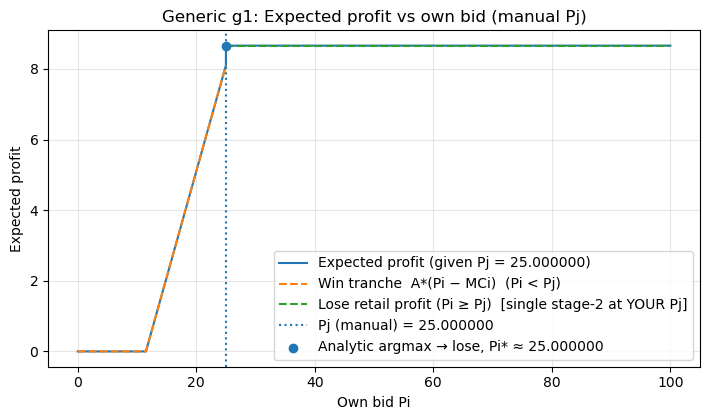

[Manual Pj] Pj = 25.000000
  Pb*(Pj)   = 151.725751
  Pg*(Pj)   = 99.910439
  Lose Π    = 8.658270  (flat for Pi ≥ Pj)
  Win Π@Pj  = 8.100000
[Argmax] Pi* = 25.000000  → lose;  E[Π] = 8.658270
[Manual Pj] 25.00
  Pi* (argmax)  = 25.000000
  E[profit]*     = 8.658270
  Lose profit    = 8.658270  (flat for Pi ≥ Pj)
  Pb*(Pj)        = 151.725751
  Pg*(Pj)        = 99.910439


In [69]:
# --- assumes Common, Gen, and plot_expected_profit_given_other_bid(...) are already defined above ---

import matplotlib.pyplot as plt

# primitives
common = Common(alpha=0.02, vb=1.5, MCb=10.8, A=0.6, tau=0.5)
g1 = Gen(name="g1", vg=0.20, MCg=11.5)
g2 = Gen(name="g2", vg=0.20, MCg=11.5)

# your manual rival bid:
Pj_manual = 25 # <-- set this to whatever you want

# plot for g1 given Pj_manual (capture output to avoid printing large arrays)
res = plot_expected_profit_given_other_bid(
    common, g1, g2,
    me_name="g1",
    Pj_manual=Pj_manual,
    Pi_min=0.0, Pi_max=100.0, Pi_points=401,
    pb_bounds=(common.MCb, 200.0),
    pg_bounds=(min(g1.MCg, g2.MCg), 200.0),
    bid_upper_for_BR=100.0
)

# print concise summary only
print(f"[Manual Pj] {Pj_manual:.2f}")
print(f"  Pi* (argmax)  = {res['Pi_star']:.6f}")
print(f"  E[profit]*     = {res['profit_star']:.6f}")
print(f"  Lose profit    = {res['lose_profit_flat']:.6f}  (flat for Pi ≥ Pj)")
print(f"  Pb*(Pj)        = {res['Pb_star_at_Pj']:.6f}")
print(f"  Pg*(Pj)        = {res['Pg_star_at_Pj']:.6f}")



In [ ]:
# ======================================================================
# Procurement + Retail MODEL (LOGIT, no-outside)
# Loser CAN ENTER the first market:
#   - First market (while A lasts): B, Winner (P), and Loser (G) compete (3-product logit)
#   - Residual (if s<1): B and Loser only (2-product logit), winner exhausted
# Scaling rule:
#   s = min(1, A / S_p^{BPG}(Pb,Pp,Pg))
# Quantities:
#   First:  s * [S_b^{BPG}, S_p^{BPG}, S_g^{BPG}]
#   Resid: (1-s) * [S_b^{BG}, 0, S_g^{BG}]
# Profits:
#   Brand: (Pb-MCb) * [ s*S_b^{BPG} + (1-s)*S_b^{BG} ]
#   Loser: (Pg-MCg) * [ s*S_g^{BPG} + (1-s)*S_g^{BG} ]
#   Winner tranche: A*(Pp - MCp)
# ======================================================================

from dataclasses import dataclass
from typing import Tuple, Dict, Optional, List
import numpy as np

# --------------------------
# Parameters
# --------------------------
@dataclass
class Common:
    alpha: float   # logit price sensitivity
    vb: float      # brand mean utility
    MCb: float     # brand marginal cost
    A: float       # tender capacity (share units out of total 1)
    tau: float = 0.5  # tie-break prob if g1=g2 exact tie

@dataclass
class Gen:
    name: str      # "g1" or "g2"
    vg: float      # generic mean utility
    MCg: float     # generic MC

# --------------------------
# Logit (no outside) helpers
# --------------------------
def shares_logit_two(p_i: float, p_j: float, Vi: float, Vj: float, alpha: float):
    """Two-product MNL (no outside): returns (s_i, s_j)."""
    di = Vi - alpha * p_i
    dj = Vj - alpha * p_j
    # numerically stable exponentials
    m  = max(di, dj)
    ei = np.exp(di - m)
    ej = np.exp(dj - m)
    Z  = ei + ej
    si = ei / Z
    sj = ej / Z
    return si, sj

def shares_logit_three(pb: float, pp: float, pg: float,
                       Vb: float, Vp: float, Vg: float, alpha: float):
    """Three-product MNL (no outside): returns (S_b, S_p, S_g)."""
    db = Vb - alpha * pb
    dp = Vp - alpha * pp
    dg = Vg - alpha * pg
    m  = max(db, dp, dg)
    eb, ep, eg = np.exp(db - m), np.exp(dp - m), np.exp(dg - m)
    Z = eb + ep + eg
    return eb/Z, ep/Z, eg/Z

# --------------------------
# Stage 2: Loser total profit (first + residual), best Pg
# --------------------------
def loser_total_profit(pg: float, pb: float, pp: float, *,
                       Vb: float, Vp: float, Vg: float,
                       MCg: float, MCb: float, A: float, alpha: float) -> Tuple[float, Dict]:
    """
    Given (pb, pp, pg), compute s, first-market 3P shares, residual BG shares,
    and the *total* loser quantity qg_total = s*S_g^{BPG} + (1-s)*S_g^{BG}.
    Return ((pg-MCg)*qg_total, details).
    """
    # First market: B, P, G all compete
    Sb3, Sp3, Sg3 = shares_logit_three(pb, pp, pg, Vb, Vp, Vg, alpha)
    # Scale/length of first market needed to sell A units for P
    if Sp3 <= 1e-12:
        s = 1.0          # if winner has ~0 share, treat as no capacity binding
    else:
        s = min(1.0, A / Sp3)
    residual = 1.0 - s

    # Residual market: B vs G (winner exhausted)
    if residual > 1e-12:
        Sb2, Sg2 = shares_logit_two(pb, pg, Vb, Vg, alpha)
    else:
        Sb2, Sg2 = 0.0, 0.0

    # Quantities
    qg_first = s * Sg3
    qg_resid = residual * Sg2
    qg_total = qg_first + qg_resid

    profit_g = max(0.0, pg - MCg) * qg_total

    return profit_g, dict(
        s=s, residual=residual,
        Sb3=Sb3, Sp3=Sp3, Sg3=Sg3,
        Sb2=Sb2, Sg2=Sg2,
        qg_first=qg_first, qg_resid=qg_resid, qg_total=qg_total
    )

def optimize_loser_price(pb: float, pp: float, *,
                         Vb: float, Vp: float, Vg: float,
                         MCg: float, MCb: float, A: float, alpha: float,
                         bounds=(0.0, 400.0)) -> Tuple[float, Dict]:
    """
    Maximize loser_total_profit(pg, pb, pp) over pg in [bounds], using
    coarse->fine bracket tightening (efficient grid).
    """
    lo, hi = bounds
    best_pg, best_val, best_info = None, -1e300, None
    for N in (401, 201, 101, 61, 31):
        grid = np.linspace(lo, hi, N)
        vals = []
        for pg in grid:
            v, info = loser_total_profit(pg, pb, pp,
                                         Vb=Vb, Vp=Vp, Vg=Vg,
                                         MCg=MCg, MCb=MCb, A=A, alpha=alpha)
            vals.append(v)
            if v > best_val:
                best_val, best_pg, best_info = v, pg, info
        idx = int(np.argmax(vals))
        # tighten bracket around the peak
        half = (grid[1] - grid[0]) * 5
        lo   = max(bounds[0], grid[max(0, idx-5)])
        hi   = min(bounds[1], grid[min(N-1, idx+5)])
    return float(best_pg), dict(best_profit=best_val, details=best_info, bracket=(lo, hi))

# --------------------------
# Stage 2: Brand total profit (with 3P first market), best Pb
# --------------------------
def brand_total_profit(pb: float, pp: float, *,
                       Vb: float, Vp: float, Vg: float,
                       MCb: float, MCg: float, A: float, alpha: float,
                       loser_bounds=(0.0, 400.0)) -> Tuple[float, Dict]:
    """
    For a given pb and tender price pp, compute loser Pg* (maximizing its total profit),
    then the brand's total quantity and profit:
      qb_total = s*Sb3 + (1-s)*Sb2
      profit_b = (pb - MCb) * qb_total
    Return (profit_b, details).
    """
    # First optimize the loser, because brand’s residual component depends on Pg*
    pg_opt, info_g = optimize_loser_price(pb, pp, Vb=Vb, Vp=Vp, Vg=Vg,
                                          MCg=MCg, MCb=MCb, A=A, alpha=alpha,
                                          bounds=loser_bounds)
    d_g = info_g["details"]
    s, residual = d_g["s"], d_g["residual"]

    # Shares at the chosen pg_opt
    Sb3, Sp3, Sg3 = shares_logit_three(pb, pp, pg_opt, Vb, Vp, Vg, alpha)
    if residual > 1e-12:
        Sb2, Sg2 = shares_logit_two(pb, pg_opt, Vb, Vg, alpha)
    else:
        Sb2, Sg2 = 0.0, 0.0

    qb_total = s * Sb3 + residual * Sb2
    profit_b = max(0.0, pb - MCb) * qb_total

    return profit_b, dict(
        pg_opt=pg_opt, loser_info=info_g,
        s=s, residual=residual,
        Sb3=Sb3, Sp3=Sp3, Sg3=Sg3,
        Sb2=Sb2, Sg2=Sg2,
        qb_total=qb_total
    )

def brand_best_price(pp: float, *,
                     Vb: float, Vp: float, Vg: float,
                     MCb: float, MCg: float, A: float, alpha: float,
                     pb_bounds=(0.0, 400.0), loser_bounds=(0.0, 400.0)) -> Tuple[float, Dict]:
    """
    Coarse->fine grid maximization for brand price pb.
    """
    lo, hi = pb_bounds
    best_pb, best_val, best_info = None, -1e300, None
    for N in (401, 201, 101, 61, 31):
        grid = np.linspace(lo, hi, N)
        vals = []
        for pb in grid:
            v, info = brand_total_profit(pb, pp, Vb=Vb, Vp=Vp, Vg=Vg,
                                         MCb=MCb, MCg=MCg, A=A, alpha=alpha,
                                         loser_bounds=loser_bounds)
            vals.append(v)
            if v > best_val:
                best_val, best_pb, best_info = v, pb, info
        idx = int(np.argmax(vals))
        lo = max(pb_bounds[0], grid[max(0, idx-5)])
        hi = min(pb_bounds[1], grid[min(N-1, idx+5)])
    return float(best_pb), dict(best_profit=best_val, details=best_info, bracket=(lo, hi))

# --------------------------
# Stage-2 wrapper at given Pp (winner/loser known)
# --------------------------
def stage2_outcomes_given_winner(pp: float, *, common: Common, winner: Gen, loser: Gen,
                                 pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0)) -> Dict:
    """
    Compute Pb* and Pg* allowing loser to participate in the first market.
    """
    pb, info_b = brand_best_price(pp, Vb=common.vb, Vp=winner.vg, Vg=loser.vg,
                                  MCb=common.MCb, MCg=loser.MCg, A=common.A, alpha=common.alpha,
                                  pb_bounds=pb_bounds, loser_bounds=pg_bounds)
    d = info_b["details"]
    pg = d["pg_opt"]
    s, residual = d["s"], d["residual"]
    Sb3, Sp3, Sg3 = d["Sb3"], d["Sp3"], d["Sg3"]
    Sb2, Sg2     = d["Sb2"], d["Sg2"]

    # Quantities
    qb_first = s * Sb3
    qp_first = s * Sp3
    qg_first = s * Sg3
    qb_res   = residual * Sb2
    qg_res   = residual * Sg2

    qb_total = qb_first + qb_res
    qp_total = qp_first                   # winner sells only in first market
    qg_total = qg_first + qg_res

    # Profits
    profit_brand = max(0.0, pb - common.MCb)  * qb_total
    profit_loser = max(0.0, pg - loser.MCg)   * qg_total
    profit_win_tranche = common.A * max(0.0, pp - winner.MCg)

    binds = (s < 1.0 - 1e-12)

    return dict(
        Pb=pb, Pg=pg, Pp=pp,
        qb_first=qb_first, qp_first=qp_first, qg_first=qg_first,
        qb_total=qb_total, qp_total=qp_total, qg_total=qg_total,
        residual_mass=residual, binds=binds,
        profit_brand_retail=profit_brand,
        profit_loser=profit_loser,
        profit_winner_tranche=profit_win_tranche,
        solver_info=info_b
    )

# --------------------------
# Bidding stage (Δ = Win - Lose), robust root with guards
# --------------------------
def expected_profit_generic_i(Pi: float, Pj: float, *, i: Gen, j: Gen, common: Common,
                              pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0)) -> float:
    """
    Profit of generic i when it bids Pi while rival j bids Pj.
      - If Pi < Pj: tranche profit A*(Pi - MCi).
      - If Pi > Pj: two-market loser profit from stage 2 (i loses, j wins).
      - If tie: τ breaks.
    """
    if Pi < Pj:
        return common.A * max(0.0, Pi - i.MCg)
    elif Pi > Pj:
        out = stage2_outcomes_given_winner(Pj, common=common, winner=j, loser=i,
                                           pb_bounds=pb_bounds, pg_bounds=pg_bounds)
        return out["profit_loser"]
    else:
        win_prob = common.tau if i.name == "g1" else (1.0 - common.tau)
        tranche = common.A * max(0.0, Pi - i.MCg)
        out_lose = stage2_outcomes_given_winner(Pj, common=common, winner=j, loser=i,
                                               pb_bounds=pb_bounds, pg_bounds=pg_bounds)["profit_loser"]
        return win_prob * tranche + (1.0 - win_prob) * out_lose

def indifference_prices(i: Gen, j: Gen, common: Common,
                        bounds=(0.0, 200.0), gridN: int = 1201,
                        pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0)) -> Tuple[Optional[float], str, Dict]:
    """
    Find P in [bounds] s.t. Δ(P)=Win-Lose=0 with guards:
      - if Δ>0 for all P -> return upper bound (wants to win at highest P)
      - if Δ<0 for all P -> return MC_i (lower bound)
      - if multiple roots -> return the LARGEST root
    """
    def delta(P):
        win = common.A * max(0.0, P - i.MCg)
        lose = stage2_outcomes_given_winner(P, common=common, winner=j, loser=i,
                                            pb_bounds=pb_bounds, pg_bounds=pg_bounds)["profit_loser"]
        return win - lose

    lo, hi = bounds
    xs = np.linspace(lo, hi, gridN)
    fs = np.array([delta(x) for x in xs])

    if np.all(fs > 0):
        return hi, "all_positive_pick_upper", {"grid": xs, "vals": fs}
    if np.all(fs < 0):
        return max(0.0, i.MCg), "all_negative_pick_MC", {"grid": xs, "vals": fs}

    idx = np.where(np.sign(fs[:-1]) * np.sign(fs[1:]) <= 0)[0]
    roots: List[float] = []
    for k in idx:
        a, b = xs[k], xs[k+1]
        fa, fb = fs[k], fs[k+1]
        for _ in range(80):
            m = 0.5*(a+b)
            fm = delta(m)
            if abs(fm) < 1e-10 or (b-a) < 1e-10:
                roots.append(m); break
            if fa*fm <= 0: b, fb = m, fm
            else:          a, fa = m, fm
        else:
            roots.append(0.5*(a+b))
    if len(roots) == 0:
        return None, "no_root_on_interval", {"grid": xs, "vals": fs}

    P_pick = max(roots)  # pick the larger root if two
    return P_pick, "ok", {"roots": roots}

def equilibrium_by_indifference(common: Common, g1: Gen, g2: Gen,
                                bid_bounds=(0.0, 200.0),
                                pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0),
                                tol_equal: float = 1e-6) -> Dict:
    P1_dag, s1, _ = indifference_prices(g1, g2, common,
                                        bounds=bid_bounds, gridN=1401,
                                        pb_bounds=pb_bounds, pg_bounds=pg_bounds)
    P2_dag, s2, _ = indifference_prices(g2, g1, common,
                                        bounds=bid_bounds, gridN=1401,
                                        pb_bounds=pb_bounds, pg_bounds=pg_bounds)
    out = {"P1_dagger": P1_dag, "P2_dagger": P2_dag, "status_g1": s1, "status_g2": s2}

    def pack(mode, Pp, w, l, reason):
        st2 = stage2_outcomes_given_winner(Pp, common=common, winner=w, loser=l,
                                           pb_bounds=pb_bounds, pg_bounds=pg_bounds)
        out.update({
            "mode": mode, "Pp_star": Pp, "winner": w.name, "loser": l.name, "reason": reason,
            "Pb_star": st2["Pb"], "Pg_star": st2["Pg"],
            "qb_first": st2["qb_first"], "qp_first": st2["qp_first"], "qg_first": st2["qg_first"],
            "qb_total": st2["qb_total"], "qp_total": st2["qp_total"], "qg_total": st2["qg_total"],
            "residual_mass": st2["residual_mass"], "binds": st2["binds"],
            "profit_winner_tranche": st2["profit_winner_tranche"],
            "profit_loser_retail": st2["profit_loser"],
            "profit_brand_retail": st2["profit_brand_retail"],
            "solver_info": st2["solver_info"],
        })
        return out

    if (P1_dag is not None) and (P2_dag is not None) and s1 == "ok" and s2 == "ok":
        if abs(P1_dag - P2_dag) <= tol_equal:
            return pack("indifference", 0.5*(P1_dag+P2_dag), g1, g2,
                        f"Equal daggers (|Δ|≤{tol_equal}).")
        else:
            Pp = max(P1_dag, P2_dag)
            return pack("indifference", Pp,
                        (g1 if P1_dag < P2_dag else g2),
                        (g2 if P1_dag < P2_dag else g1),
                        "Different daggers: Pp=max{P1†,P2†}; lower-† firm wins.")

    # Guard/partial: at least one side was a guard result
    picks = []
    for P_dag, status, who in [(P1_dag, s1, g1), (P2_dag, s2, g2)]:
        if status in ("all_positive_pick_upper", "all_negative_pick_MC", "ok"):
            if P_dag is not None:
                picks.append((P_dag, who))
    if len(picks) >= 1:
        Pp, w = min(picks, key=lambda x: x[0])  # lower bid wins
        l = g2 if w is g1 else g1
        return pack("guard_or_partial", Pp, w, l, f"Guard/partial result (status: {s1}, {s2}).")

    # Last fallback
    Pp = 0.5*(bid_bounds[0]+bid_bounds[1])
    return pack("fallback_mid", Pp, g1, g2, "No clean roots; fallback mid.")

# --------------------------
# Pretty printer
# --------------------------
def print_equilibrium_summary(common: Common, g1: Gen, g2: Gen,
                              bid_bounds=(0.0, 200.0),
                              pb_bounds=(0.0, 400.0), pg_bounds=(0.0, 400.0)):
    eq = equilibrium_by_indifference(common, g1, g2,
                                     bid_bounds=bid_bounds,
                                     pb_bounds=pb_bounds, pg_bounds=pg_bounds)

    print("=== Indifference bids ===")
    print(f"P1† (g1 vs g2): {eq['P1_dagger']}  status: {eq['status_g1']}")
    print(f"P2† (g2 vs g1): {eq['P2_dagger']}  status: {eq['status_g2']}")
    print(f"\n=== Equilibrium ({eq['mode']}) ===")
    print(eq["reason"])
    print(f"Pp* (procurement price): {eq['Pp_star']}")
    print(f"Winner: {eq['winner']}   Loser: {eq['loser']}")

    print("\nStage-2 outcomes at Pp*:")
    print(f"  Pb* (brand):          {eq['Pb_star']:.4f}")
    print(f"  Pg* (loser):          {eq['Pg_star']:.4f}")
    print(f"  First-stage qty (B,P,G):  {eq['qb_first']:.4f}, {eq['qp_first']:.4f}, {eq['qg_first']:.4f}")
    print(f"  Residual mass:        {eq['residual_mass']:.4f}   Capacity binds? {eq['binds']}")
    print(f"  Totals (B,P,G):       {eq['qb_total']:.4f}, {eq['qp_total']:.4f}, {eq['qg_total']:.4f}")
    print("Profits:")
    print(f"  Winner tranche:       {eq['profit_winner_tranche']:.4f}")
    print(f"  Loser (retail):       {eq['profit_loser_retail']:.4f}")
    print(f"  Brand (retail):       {eq['profit_brand_retail']:.4f}")

# --------------------------
# Example usage
# --------------------------
if __name__ == "__main__":
    # Example primitives (adjust to your case)
    common = Common(alpha=0.02, vb=1.50, MCb=12.0, A=0.40, tau=0.5)
    g1 = Gen(name="g1", vg=0.20, MCg=11.5)
    g2 = Gen(name="g2", vg=0.25, MCg=12.0)  # asymmetry allowed

    # Bids are constrained: lower bound at MC; upper bound at 120 (example)
    bid_lb = max(g1.MCg, g2.MCg)
    print_equilibrium_summary(common, g1, g2,
                              bid_bounds=(bid_lb, 120.0),
                              pb_bounds=(0.0, 220.0), pg_bounds=(0.0, 180.0))
